<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#¿Qué-es-una-Serie-Temporal?" data-toc-modified-id="¿Qué-es-una-Serie-Temporal?-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>¿Qué es una Serie Temporal?</a></span></li><li><span><a href="#Exploración-de-los-datos" data-toc-modified-id="Exploración-de-los-datos-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Exploración de los datos</a></span><ul class="toc-item"><li><span><a href="#Conversión-de-la-columna-date-a-datetime" data-toc-modified-id="Conversión-de-la-columna-date-a-datetime-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Conversión de la columna date a datetime</a></span></li><li><span><a href="#Chequeemos-los-nulos." data-toc-modified-id="Chequeemos-los-nulos.-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Chequeemos los nulos.</a></span></li></ul></li><li><span><a href="#Componentes-de-una-Serie-Temporal" data-toc-modified-id="Componentes-de-una-Serie-Temporal-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Componentes de una Serie Temporal</a></span><ul class="toc-item"><li><span><a href="#Estacionalidad" data-toc-modified-id="Estacionalidad-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Estacionalidad</a></span></li><li><span><a href="#Estacionaridad" data-toc-modified-id="Estacionaridad-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Estacionaridad</a></span></li><li><span><a href="#Comparativa-estacionalidad-vs-estacionaridad" data-toc-modified-id="Comparativa-estacionalidad-vs-estacionaridad-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Comparativa estacionalidad vs estacionaridad</a></span></li></ul></li><li><span><a href="#Autocorrelación" data-toc-modified-id="Autocorrelación-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Autocorrelación</a></span></li><li><span><a href="#Modelo-ARMA" data-toc-modified-id="Modelo-ARMA-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Modelo ARMA</a></span></li></ul></div>

In [13]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]


## Para sacar los componentes de la serie temporal
################################################################
from statsmodels.tsa.seasonal import seasonal_decompose


## Para calcular la estacionaridad de nuestras series temporales
################################################################
from statsmodels.tsa.stattools import adfuller

## Para calcular la autocorrelación en la serie temporal
################################################################
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

## Para ajustar los modelos predictivos
################################################################
from statsmodels.tsa.arima.model import ARIMA
from itertools import product

## Para las metricas del modelo
################################################################
from sklearn.metrics import mean_squared_error

## Para ignorar los warnings
################################################################
import warnings
warnings.filterwarnings("ignore")


# ¿Qué es una Serie Temporal?

Una Serie Temporal, es una sucesión de datos medidos en determinados momentos y ordenados cronológicamente. Los datos pueden estar espaciados a intervalos iguales (como la temperatura en un observatorio meteorológico en días sucesivos al mediodía) o desiguales (como el peso de una persona en sucesivas mediciones en el consultorio médico, la farmacia, etc.).

Cuando estamos trabajando con Series Temporales nos tenemos que hacer las siguientes preguntas: 

- ¿Es estacionario?

- ¿Hay una estacionalidad?

- ¿Los datos están autocorrelacionados?

# Exploración de los datos

In [2]:
df = pd.read_csv("data/caramelos.csv", index_col = 0)
df.head()

,date,IPG3113N
0,1972-01-01,85.598809
1,1972-02-01,71.741404
2,1972-03-01,65.948809
3,1972-04-01,64.490724
4,1972-05-01,64.933842


In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
IPG3113N,564.0,101.136666,18.131158,50.680157,88.344728,102.777853,114.928399,139.302096


## Conversión de la columna date a datetime
Para trabajar con Series Temporales debemos asegurarnos de que la columna de fecha esta en formato `datetime`, que este como índice y debe tener alguna frecuencia. Veamos como hacerlo: 

In [4]:
df.dtypes

date         object
IPG3113N    float64
dtype: object

In [5]:
# colocamos la columna a datetime y la ponemos como índice
df.index = pd.to_datetime(df["date"])
df.head()

,date,IPG3113N
date,,
1972-01-01,1972-01-01,85.598809
1972-02-01,1972-02-01,71.741404
1972-03-01,1972-03-01,65.948809
1972-04-01,1972-04-01,64.490724
1972-05-01,1972-05-01,64.933842


In [6]:
# veamos como es nuestro índice
df.index

DatetimeIndex(['1972-01-01', '1972-02-01', '1972-03-01', '1972-04-01',
               '1972-05-01', '1972-06-01', '1972-07-01', '1972-08-01',
               '1972-09-01', '1972-10-01',
               ...
               '2018-03-01', '2018-04-01', '2018-05-01', '2018-06-01',
               '2018-07-01', '2018-08-01', '2018-09-01', '2018-10-01',
               '2018-11-01', '2018-12-01'],
              dtype='datetime64[ns]', name='date', length=564, freq=None)

Si nos fijamos nuestra columna de momento no tiene frecuencia. Para cambiarlo usaremos el método `infer_freq` de pandas

In [7]:
df.index.freq = pd.infer_freq(df.index)
df.index

DatetimeIndex(['1972-01-01', '1972-02-01', '1972-03-01', '1972-04-01',
               '1972-05-01', '1972-06-01', '1972-07-01', '1972-08-01',
               '1972-09-01', '1972-10-01',
               ...
               '2018-03-01', '2018-04-01', '2018-05-01', '2018-06-01',
               '2018-07-01', '2018-08-01', '2018-09-01', '2018-10-01',
               '2018-11-01', '2018-12-01'],
              dtype='datetime64[ns]', name='date', length=564, freq='MS')

Si nos fijamos ahora Pandas automaticamente ha detectado la frecuencia, es de día. 

In [8]:
df.head()

,date,IPG3113N
date,,
1972-01-01,1972-01-01,85.598809
1972-02-01,1972-02-01,71.741404
1972-03-01,1972-03-01,65.948809
1972-04-01,1972-04-01,64.490724
1972-05-01,1972-05-01,64.933842


In [9]:
# por último eliminamos la columna de DATE que ya no nos hace falta. 
df.drop(columns=['date'], inplace=True)
df.head()

,IPG3113N
date,
1972-01-01,85.598809
1972-02-01,71.741404
1972-03-01,65.948809
1972-04-01,64.490724
1972-05-01,64.933842


## Chequeemos los nulos. 

🚨🚨🚨 No podremos tenere nulos en el *dataframe*

In [10]:
df.isnull().sum()

IPG3113N    0
dtype: int64

In [11]:
df.columns = ["valores"]

# Componentes de una Serie Temporal

El análisis clásico de series temporales considera que una serie temporal queda formada por cuatro
componentes:

- `Tendendia o Estacionaridad`: movimiento regular de la serie, a largo plazo.


- `Variaciones estacionales`: oscilaciones a corto plazo del período regular, de duración menor o igual a un año.


- `Variaciones cíclicas`: movimientos a medio plazo (superior a un año) en torno a la tendencia cuyo período y amplitud pueden presentar cierta regularidad.


- `Ruido Blanco o residuos`: consisten en movimientos irregulares y pasajeros provocados por factores esporádicos e imprevisibles. Son efectos impredecibles que no son asignables a ninguna de las componentes anteriores, por lo que constituyen el residuo que queda cuando se estiman las otras componentes.

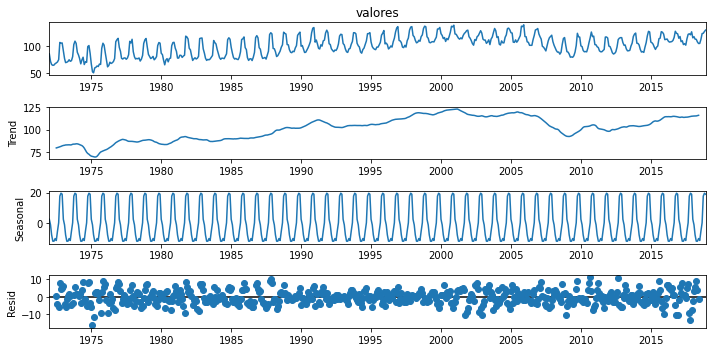

In [14]:
res = seasonal_decompose(df.valores, model="additive")
res.plot();

## Estacionalidad


Un patrón estacional se produce cuando una serie temporal se ve afectada por factores estacionales, como la época del año o el día de la semana. La estacionalidad tiene siempre una frecuencia fija y conocida.



In [ ]:
df2 = df.copy()
df2.head()

In [ ]:
df2["year"] = df2.index.year
df2["month"] = df2.index.month
df2.head()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))

sns.lineplot(df2['month'], df2['valores'], hue=df2['year'])
ax.set_title('Estacionalidad venta caramelos', fontsize = 20, loc='center')
ax.set_xlabel('Mes')
ax.set_ylabel('Caramelos vendidos');

## Estacionaridad

Existe una tendencia cuando hay un aumento o una disminución a largo plazo en los datos. No tiene por qué ser lineal. A veces se dice que una tendencia "cambia de dirección" cuando puede pasar de una tendencia creciente a una tendencia decreciente. Se puede decir que una serie es estacionaria cuando **su media y su varianza no están en función del tiempo**, es decir, son constantes en el tiempo.

La estacionariedad es importante porque la mayoría de los métodos estadísticos para realizar análisis y predicciones se basan en la suposición de que las propiedades estadísticas de la serie (media, varianza, correlación, etc.) son constantes en el tiempo.

In [ ]:
df.plot(figsize=(15,6))
plt.title("Evolución de la temperatura")
plt.axhline(df.valores.mean(), c="g", label="mean")
plt.legend();


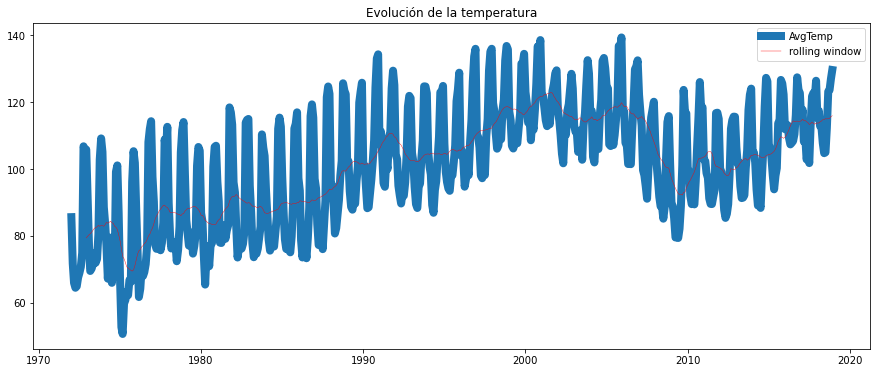

In [16]:
plt.figure(figsize=(15,6))
plt.title("Evolución de la temperatura")

plt.plot(df["valores"], label="AvgTemp", linewidth=8)
plt.plot(df.rolling(window = 12).mean(), label="rolling window", c= "r", linewidth = 0.4)

plt.legend();

Al plotear la media junto con los puntos de datos originales, podemos ver que son  algo constantes en el tiempo, no vemos ninguna tendencia de incremento o disminución. Sin embargo, parecen seguir un comportamiento. cíclico. Pero esto nos puede convencer poco, también podemos hacer el test de ADFuller

In [17]:
res_ad = adfuller(df["valores"])
res_ad

(-1.7760153075016094,
 0.39243275007140066,
 14,
 549,
 {'1%': -3.4423174665535385,
  '5%': -2.866818952732754,
  '10%': -2.569581505602171},
 3094.8288813170466)

In [18]:
# pongamosle etiquetas a los resultados
print('ADF Statistic:', res_ad[0])
print('p-value:', res_ad[1])
print('Critical Values:')
for key, value in res_ad[4].items():
	print( "\t",  key, round(value, 2))

ADF Statistic: -1.7760153075016094
p-value: 0.39243275007140066
Critical Values:
	 1% -3.44
	 5% -2.87
	 10% -2.57


¿Cuáles son las conclusiones de esta prueba?

A partir de los resultados del test de Dickey Fuller podemos observar dos cosas:

- Si adf > valores_críticos  ==> DATOS NO ESTACIONARIOS

- pvalue> 0.05  ==> DATOS NO ESTACIONARIOS

En nuestro caso, nuestros datos no son estacionarios! 

In [19]:
df["diff"] = df.diff()
df.head()

,valores,diff
date,,
1972-01-01,85.598809,NaN
1972-02-01,71.741404,-13.857405
1972-03-01,65.948809,-5.792594
1972-04-01,64.490724,-1.458086
1972-05-01,64.933842,0.443118


In [20]:
df.drop(["valores"], inplace = True, axis = 1)
df.dropna(inplace = True)

In [21]:
df.head()

,diff
date,
1972-02-01,-13.857405
1972-03-01,-5.792594
1972-04-01,-1.458086
1972-05-01,0.443118
1972-06-01,2.630546


In [22]:
res_ad2 = adfuller(df["diff"])
res_ad2

(-6.175912489755725,
 6.631549159333205e-08,
 13,
 549,
 {'1%': -3.4423174665535385,
  '5%': -2.866818952732754,
  '10%': -2.569581505602171},
 3091.3123583091397)

In [23]:
print('ADF Statistic:', res_ad[0])
print('p-value:', res_ad[1])
print('Critical Values:')
for key, value in res_ad2[4].items():
	print( "\t",  key, round(value, 2))

ADF Statistic: -1.7760153075016094
p-value: 0.39243275007140066
Critical Values:
	 1% -3.44
	 5% -2.87
	 10% -2.57


## Comparativa estacionalidad vs estacionaridad

In [ ]:
# nos creamos una lista con las columnas de tiempo
tiempo = df2.columns.drop("valores")

componentes = ["Estacionaridad", "Estacionalidad"]

#iniciamos los subplots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# hacemos nuestro for para no repetir lineas de código
for i, col in enumerate(tiempo):
    sns.boxplot(df2[col], df2["valores"], ax=ax[i])
    ax[i].set_title(componentes[i], fontsize = 20, loc='center')
    ax[i].set_xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
    ax[i].set_ylabel('caramelos', fontsize = 16)
plt.show()

# Autocorrelación

La autocorrelación es un tipo de dependencia temporal. En concreto, la autocorrelación se produce cuando una serie temporal está relacionada linealmente con una versión retardada de la misma. 


Quizás el aspecto más convincente del análisis de autocorrelación es cómo puede ayudarnos a descubrir patrones ocultos en nuestros datos y a seleccionar los métodos de previsión correctos. En concreto, podemos utilizarlo para ayudar a identificar la estacionalidad y la tendencia en nuestros datos de series temporales. Además, el análisis conjunto de la función de autocorrelación (ACF) y la función de autocorrelación parcial (PACF) es necesario para seleccionar el modelo ARIMA adecuado para la predicción de series temporales.

- `Auto-correlación`: la correlación entre dos momentos/instantes de tiempo.


- `Auto-correlación parcial`: es una medida de la correlación entre observaciones de una serie de tiempo que se encuentran separadas por k unidades de tiempo (yt y yt-k), después de ajustarse para la presencia de los demás términos de desfase más corto (yt-1, yt-2, ..., yt–k–1).

![auto](https://github.com/Ironhack-Part-Time-Enero2022/apuntes-clases/blob/master/semana-20/imagenes/autocorrelation-anatomy-python.jpg?raw=true)

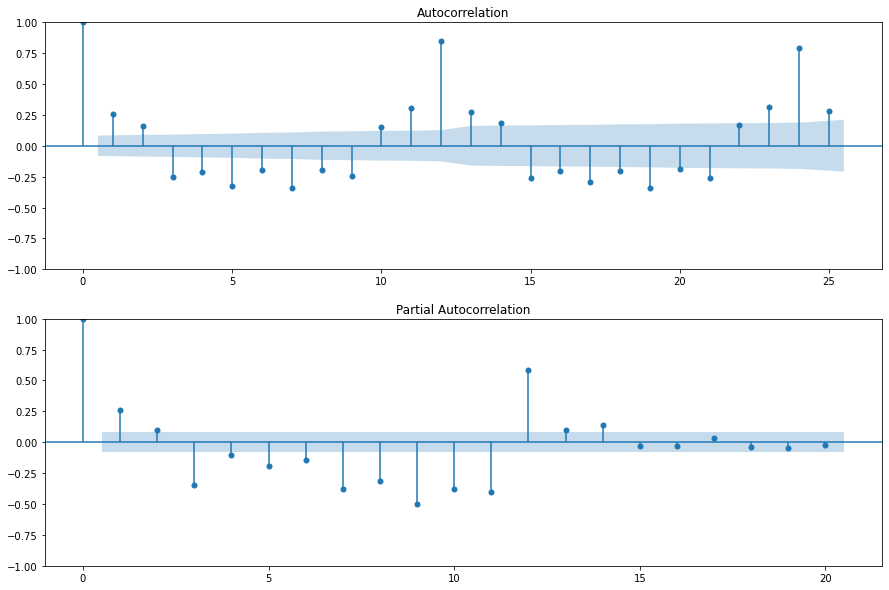

In [24]:
fig, axes = plt.subplots(2, 1, figsize=(15,10))
plot_acf(df, lags=25, ax= axes[0])
plot_pacf(df, lags=20, ax= axes[1]);



# Modelo ARMA

Para hacer predicciones necesitaremos usar los modelos ARMA o ARIMA. ¿Qué signfican estos conceptos? 

Lo primero que tenemos que hacer es separar nuestros datos en *train* y *test*, para seguir con buenas prácticas y ver si nuestras predicciones están *overfiteadas* 

In [25]:
y_test = df["diff"][-30:]
y_train = df["diff"][:-30]

In [26]:
ps = range(24)
qs = range(15)

parameters = list(product(ps, ds, qs))
parameters[:10]

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 0, 3),
 (0, 0, 4),
 (0, 0, 5),
 (0, 0, 6),
 (0, 0, 7),
 (0, 0, 8),
 (0, 0, 9)]

In [ ]:
%%time
rmse = []
order = []
for p,q, d in tqdm(parameters):
    try:
        modelo=ARIMA(y_train, order=(p, 0, q)).fit()
        pred = modelo.predict(start=len(y_train), end=len(df) -1)
        error = np.sqrt(np.mean(mean_squared_error(y_test, pred)))
        rmse.append(error)
        order.append((p,d,q))
    except: 
        continue

 98%|████████████████████████████████████████ | 703/720 [1:43:48<07:32, 26.63s/it]

In [ ]:
results = pd.DataFrame({"RMSE": rmse, "order": order})
results.sort_values(by="RMSE", inplace=True)

In [ ]:
results.head()

In [ ]:
modelo=ARIMA(y_train, order=(4, 1, 5)).fit()
pred = pd.DataFrame(modelo.predict(start=len(y_train), end=len(df) -1))

In [ ]:
fecha = pd.date_range("2016-07-01  ", periods=30, freq="MS")

In [ ]:
pred.index = fecha

In [ ]:
pred.head()

In [ ]:
plt.plot(y_train)
plt.plot(pred)
plt.legend(["real", "predicted"]);

In [ ]:
pred["real"] = y_test

In [ ]:
pred.head()

In [ ]:
plt.plot(pred['predicted_mean'])
plt.plot(pred["real"])
plt.legend(["real", "predicted"]);

In [ ]:
y_test

In [ ]:
fecha2 = pd.date_range("2019-01-01  ", periods=12, freq="MS")
fecha2

In [ ]:
pred2 = pd.DataFrame(modelo.predict(start=len(df) , end=len(df)  + 12))

In [ ]:
pred2

In [ ]:
plt.plot(df)
plt.plot(pred2)
plt.legend(["real", "predicted"]);

In [ ]:
df.head()

In [ ]:
df2 = df[df.index.year > 2017]
df2.head()

In [ ]:
plt.plot(df2)
plt.plot(pred2)
plt.legend(["real", "predicted"]);